<a href="https://colab.research.google.com/github/IsinghGitHub/CellStrat/blob/master/Food_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genpact Machine Learning Hackathon


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Demand-ForeCasting')
!pwd

/content/gdrive/My Drive/Colab Notebooks/Demand-ForeCasting


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
pip install catboost

     |████████████████████████████████| 62.5MB 1.6MB/s 


In [0]:
import gc
import catboost as cb
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold

In [0]:
#pd.set_option('display.max_rows', None)
def show_all(df, nrow, ncol):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [0]:
FILES_PATH = "/content/gdrive/My Drive/Colab Notebooks/Demand-ForeCasting/data/train_GzS76OK"
SUB_PATH = "/content/gdrive/My Drive/Colab Notebooks/Demand-ForeCasting"

In [0]:
fci_df = pd.read_csv("./data/train_GzS76OK/fulfilment_center_info.csv")
mi_df = pd.read_csv("./data/train_GzS76OK/meal_info.csv")
train_df = pd.read_csv("./data/train_GzS76OK/train.csv")
test_df = pd.read_csv("./data/test.csv")
sub_df = pd.read_csv("./data/sample_submission.csv")

In [0]:
from google.colab import drive
#drive.mount('/content/drive')

In [14]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [0]:
# head of fulfilment_center_info file
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [15]:
print("Shape of fulfilment_center_info :", fci_df.shape)

Shape of fulfilment_center_info : (77, 5)


In [16]:
# NaN values in fulfilment_center_info
fci_df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [17]:
# head of meal_info file
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [18]:
print("Shape of meal_info: ", mi_df.shape)

Shape of meal_info:  (51, 3)


In [19]:
# NaN values in meal_info
mi_df.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [0]:
# Head of Train file (historical demand data)
#train_df.head()

In [21]:
print("Shape of train: ", train_df.shape)

Shape of train:  (456548, 9)


In [22]:
# NaN values in train data
train_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [23]:
# Head of Test data
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [24]:
print("Shape of Test: ", test_df.shape)

Shape of Test:  (32573, 8)


In [25]:
# NaN values in test data
test_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [0]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [27]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [0]:
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'

In [0]:
train_df['num_orders'] = np.log1p(train_df['num_orders'])

In [30]:
train_df['num_orders']

0         5.181784
1         5.780744
2         4.574711
3         5.099866
4         5.375278
5         5.655992
6         5.003946
7         4.912655
8         5.170484
9         5.170484
10        5.501258
11        5.252273
12        4.234107
13        4.912655
14        5.905362
15        4.219508
16        5.602119
17        5.860786
18        5.501258
19        5.241747
20        4.919981
21        5.693732
22        5.241747
23        5.087596
24        4.025352
25        5.176150
26        5.313206
27        5.693732
28        4.682131
29        4.912655
            ...   
456518    2.639057
456519    4.219508
456520    4.007333
456521    3.737670
456522    3.332205
456523    2.708050
456524    3.295837
456525    3.367296
456526    2.708050
456527    3.988984
456528    4.007333
456529    3.367296
456530    3.988984
456531    4.804021
456532    5.937536
456533    5.602119
456534    5.828946
456535    4.682131
456536    3.737670
456537    3.367296
456538    2.772589
456539    3.

In [31]:
all_df = train_df.append(test_df).reset_index(drop=True)[train_df.columns]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [0]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [0]:
all_df['checkout_price'] = np.log1p(all_df['checkout_price'])
all_df['base_price'] = np.log1p(all_df['base_price'])

In [0]:
all_df['discount_on_base'] = (all_df['base_price'] - all_df['checkout_price']) / all_df['base_price']

In [35]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095


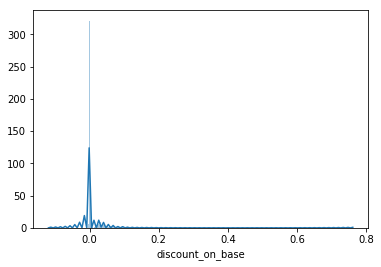

In [36]:
sns.distplot(all_df['discount_on_base'], bins=500)
plt.show()

In [0]:
all_df['neg_discount'] = (all_df['discount_on_base'] < 0).astype(int)

In [0]:
all_df['price_last_curr_diff'] = (all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)/ all_df['checkout_price'].shift(1).fillna(1)

In [0]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'price_last_curr_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['price_last_curr_diff'].mean()

In [0]:
all_df['price_last_curr_diff'] = all_df['price_last_curr_diff'].fillna(0)

In [0]:
all_df['price_increase'] = (all_df['price_last_curr_diff'] < 0).astype(int)

In [42]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082,1,-0.001037,1
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043,0,0.002077,0
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095,1,-0.001075,1


#### Some functions to create aggregated, rolling mean/median, and exponentially weighted features.


In [0]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

In [0]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling mean features
def create_sales_rmean_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                             shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmean', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).mean().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df


# Creating sales rolling median features
def create_sales_rmed_feats(df, gpby_cols, target_col, windows, min_periods=2, 
                            shift=1, win_type=None):
    gpby = df.groupby(gpby_cols)
    for w in windows:
        df['_'.join([target_col, 'rmed', str(w)])] = \
            gpby[target_col].shift(shift).rolling(window=w, 
                                                  min_periods=min_periods,
                                                  win_type=win_type).median().values +\
            np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [0]:
def one_hot_encoder(df, ohe_cols):
    '''
    One-Hot Encoder function
    '''
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df = pd.get_dummies(df, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df

In [0]:
# # Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
all_df = create_sales_lag_feats(all_df, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11, 12])

## all_df = create_sales_rmean_feats(all_df, gpby_cols=['center_id','meal_id'], 
##                                 target_col='num_orders', windows=[26,52,104], 
##                                 min_periods=3, win_type='triang')

## all_df = create_sales_rmed_feats(all_df, gpby_cols=['center_id','meal_id'], 
##                                 target_col='num_orders', windows=[26,52,104], 
##                                 min_periods=3, win_type=None)

all_df = create_sales_ewm_feats(all_df, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.5], 
                               shift=[10,11,12,13,14,15])


In [47]:
all_df.shape

(489121, 29)

In [48]:
show_all(all_df, 5, None)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base,neg_discount,price_last_curr_diff,price_increase,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000,0,0.000086,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044,1,-0.002064,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489119,1429037,115,186,2956,6.366522,6.369952,0,0,2.772589,649,34,TYPE_A,3.4,Fish,Continental,train,0.000539,0,0.000539,0,5.17118,4.020094,4.800327,3.097631,3.556204,3.398836,3.430377,3.564916,3.392163
489120,1285049,116,186,2956,5.680275,6.368239,0,0,4.812184,649,34,TYPE_A,3.4,Fish,Continental,train,0.108030,0,0.107790,0,4.79324,3.400057,6.598399,3.405601,3.097631,3.556204,3.398836,3.430377,3.564916


In [0]:
trn = all_df.loc[all_df['train_or_test']=='train', :]
test = all_df.loc[all_df['train_or_test']=='test', :]

In [50]:
trn.shape

(456548, 29)

In [51]:
test.shape

(32573, 29)

In [52]:
trn.isnull().sum()

id                               0
week                             0
center_id                        0
meal_id                          0
checkout_price                   0
base_price                       0
emailer_for_promotion            0
homepage_featured                0
num_orders                       0
city_code                        0
region_code                      0
center_type                      0
op_area                          0
category                         0
cuisine                          0
train_or_test                    0
discount_on_base                 0
neg_discount                     0
price_last_curr_diff             0
price_increase                   0
num_orders_lag_10            35843
num_orders_lag_11            39412
num_orders_lag_12            42980
num_orders_lag_10_ewm_0.5       10
num_orders_lag_11_ewm_0.5       11
num_orders_lag_12_ewm_0.5       12
num_orders_lag_13_ewm_0.5       13
num_orders_lag_14_ewm_0.5       14
num_orders_lag_15_ew

### Catboost

In [0]:
avoid_columns1 = ['id', 'num_orders', 'train_or_test', 'checkout_price', 'base_price', 'city_code', 'region_code', 'center_type', '']

In [0]:
features1 = [col for col in test.columns if col not in avoid_columns1]

In [55]:
features1

['week',
 'center_id',
 'meal_id',
 'emailer_for_promotion',
 'homepage_featured',
 'op_area',
 'category',
 'cuisine',
 'discount_on_base',
 'neg_discount',
 'price_last_curr_diff',
 'price_increase',
 'num_orders_lag_10',
 'num_orders_lag_11',
 'num_orders_lag_12',
 'num_orders_lag_10_ewm_0.5',
 'num_orders_lag_11_ewm_0.5',
 'num_orders_lag_12_ewm_0.5',
 'num_orders_lag_13_ewm_0.5',
 'num_orders_lag_14_ewm_0.5',
 'num_orders_lag_15_ewm_0.5']

In [0]:
cat_ind1 = [1, 2, 3, 4, 6, 7, 9, 11]

In [0]:
cat_rg1 = cb.CatBoostRegressor(iterations=625, learning_rate=0.06, depth=8, l2_leaf_reg=10, loss_function='RMSE', random_seed=2018)

In [58]:
cat_rg1.fit(X=trn[features1], y=trn['num_orders'], cat_features=cat_ind1, verbose=True)

0:	learn: 1.1544216	total: 563ms	remaining: 5m 51s
1:	learn: 1.1092692	total: 983ms	remaining: 5m 6s
2:	learn: 1.0678277	total: 1.45s	remaining: 4m 59s
3:	learn: 1.0292629	total: 1.86s	remaining: 4m 48s
4:	learn: 0.9938765	total: 2.31s	remaining: 4m 46s
5:	learn: 0.9609276	total: 2.74s	remaining: 4m 42s
6:	learn: 0.9306726	total: 3.16s	remaining: 4m 39s
7:	learn: 0.9026091	total: 3.61s	remaining: 4m 38s
8:	learn: 0.8766811	total: 4.06s	remaining: 4m 37s
9:	learn: 0.8524846	total: 4.46s	remaining: 4m 34s
10:	learn: 0.8304929	total: 4.88s	remaining: 4m 32s
11:	learn: 0.8102626	total: 5.33s	remaining: 4m 32s
12:	learn: 0.7912315	total: 5.75s	remaining: 4m 30s
13:	learn: 0.7738018	total: 6.2s	remaining: 4m 30s
14:	learn: 0.7581206	total: 6.64s	remaining: 4m 29s
15:	learn: 0.7434516	total: 7.07s	remaining: 4m 28s
16:	learn: 0.7298923	total: 7.49s	remaining: 4m 28s
17:	learn: 0.7174815	total: 7.9s	remaining: 4m 26s
18:	learn: 0.7063502	total: 8.33s	remaining: 4m 25s
19:	learn: 0.6949579	tota

624:	learn: 0.4839052	total: 8m 15s	remaining: 0us

In [0]:
pred = cat_rg1.predict(test[features1])

In [0]:
pred = (np.exp(pred) - 1)

In [0]:
sub_df = pd.DataFrame(columns=['id', 'num_orders'])
sub_df['id'] = test['id']
sub_df['num_orders'] = pred
sub_df.to_csv(f'{SUB_PATH}/cat10.csv', index=False)

In [0]:
# for catboost plots
# jupyter nbextension enable --py widgetsnbextension
# https://www.slideshare.net/OwenZhang2/tips-for-data-science-competitions